# Digit Recognization - Keras

## MNIST Datasets

<img src="files/mnist-sample.png">

##### Imports

In [36]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# to convert to one-hot-encoding
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

### 1. Data Preparation

##### Load the data

In [2]:
train = pd.read_csv("./datasets/train.csv")
test = pd.read_csv("./datasets/test.csv")

In [3]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels= ["label"], axis=1)

# free some space
del train

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

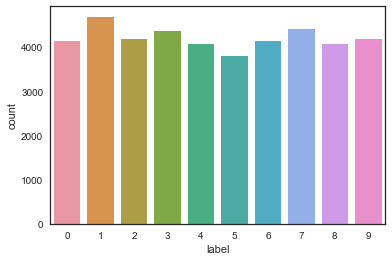

In [4]:
g = sns.countplot(Y_train)

Y_train.value_counts()

##### Check for null and missing values

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Here we checked for corrupted images (i.e. missing values inside.)

There are no missings values in the train and test dataset. So we can safely go ahead

##### Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences

Moreover, the CNN converged faster on [0..1] data than on [0..255]

In [7]:
X_train = X_train / 255.0
test = test / 255.0

##### Reshape

Reshape image in 3 dimensional (height = 28px, width = 28px, canal = 1)

In [8]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

Train and test images (28px X 28px) has been stock into pandas. Dataframes as ID vectors of 784 values. We reshape all data to 28x28x1 3D matraices

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matraics

##### Label encoding

Encode labels to one hot vectors (ex: 2 -> [0,0,1,0,0,0,0,0,0,0])

In [9]:
Y_train = to_categorical(Y_train, num_classes=10)

Labels are 10 digits numbers from 0 to 9. We need to encode these labels to one hot vectors.

##### Split training and validation set

In [10]:
# setting random seed
random_seed = 2

In [11]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

Here we choosed to split the train set in two parts: a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42000 training images of balanced labels, a random split of the train set doesn't cause some labels to be over represented in the validation set. Be careful with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

To avoid that, we could usse `stratify = True` option in `train_test_split` function (**Only for >= 0.17 sklearn versions**).

We can get a better sense for one of these examples by visualising the image and looking at the label.

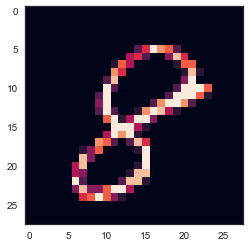

In [12]:
g = plt.imshow(X_train[0][:,:,0])

### 2. CNN

##### Define the model

We used the Keras Sequential API, where we have just to add one layer at a time, starting from the input.

The first is the convolution (Conv2D) layer. It is like a set of learnable filters. We choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (features maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e. the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a proportion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x)). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolution/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end, We used the features in two fully-connected (Dense) layers which is just artificial neural network (ANN) classifier. In the last layer (`Dense(10, activiation="softmax")`) the net outputs distribution of probability of each class.

Here, CNN Model -> 
[[Conv2D->relu]*2 -> MaxPool2D -> Dropout] * 2 -> Flatten -> Dense -> Dropput -> Out

In [13]:
model = Sequential()

model.add(Conv2D(filters=32, 
                 kernel_size=(5,5), 
                 padding='Same', 
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, 
                 kernel_size=(5,5), 
                 padding='Same', 
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))


model.add(Conv2D(filters=64, 
                 kernel_size=(3,3), 
                 padding='Same', 
                 activation='relu'))
model.add(Conv2D(filters=64, 
                 kernel_size=(3,3), 
                 padding='Same', 
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

##### Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimization algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the observed labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons...) in order to minimise the loss.

We choosed RMSProp (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could have used Stochastic Gradient Descent ('sdg') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation)

In [15]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [16]:
# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

<img src="files/learningrates.jpg">

In order to make the optimizer converge faster and closest to the global minimun of the loss function, we used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the "loss landscape". The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimun of the loss function.

To keep the advantage of the last computation time with a high LR, we  decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the `ReducedLROnPlateau` function from `Keras.callbacks`, we choose to reduce the LR by half if the accuracy is not improved after 2 epochs.

In [19]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [20]:
EPOCHS = 1
batch_size = 86

##### Data Augmentation

In order to avoid overfitting problem, we need to expand artifically our handwritten digit dataset. We can make our existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered, the scale is not the same (some who write with big/small numbers), the image is rotated etc.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [22]:
# Without data augmentation
# history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=EPOCHS, validation_data=(X_val, Y_val), verbose=2)

# With data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each inputs by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=10, # randomly rotate images in the range (degrees, 0 to 10)
    zoom_range=0.1, # Randomly zoom image
    width_shift_range=0.1, # randomly shift image horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift image vertically (fraction of total height)
    horizontal_flip=False, # randomly flip images horizontally
    vertical_flip=False # randomly flip images vertically
)

datagen.fit(X_train)

For the data augmentation, we choosed to:
- Randomly rotate some training images by upto 10 degrees
- Randomly zoom some training images by upto 10%
- Randomly shift images horizontally by upto 10% of the width
- Randomly shift images vertically by upto 10% of the height

We did not apply a `vertical_flip` nor `horizontal_flip` since it could have lead to misclassify symetrical numbers such as 6 and 9

Once our model is ready, we fit the training dataset.

In [26]:
# Fit the model
history = model.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=batch_size), 
    epochs=EPOCHS, 
    validation_data=(X_val, Y_val), 
    verbose=2, 
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction])

Epoch 1/1
 - 341s - loss: 0.2521 - acc: 0.9215 - val_loss: 0.0521 - val_acc: 0.9840


### 3. Evaluate the model

##### Training and validation curves

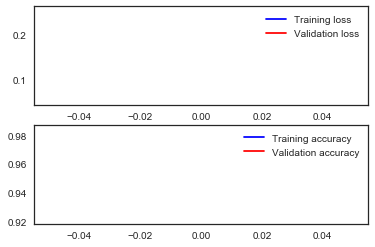

In [32]:
# Plot the loss and accuracy curves for traning and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax[0])

legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r', label="Validation accuracy")

legend = ax[1].legend(loc='best', shadow=True)

The code below is for plotting loss and accuracy curves for training and validation. Since, we set epochs = 1 on this notebook, below attached training and validation curves obtained from the model build with 30 epochs

<img src="files/mnist_099671_train_val_loss_acc.png">

The model reaches almost 99% (98.7+%) accuracy on the validation dataset after 2 epochs). The validation accuracy is greater than the training accuracy almost every time during the training. That means that our model doesn't overfit the training set.

Our model is very well trained!!!

<img src="files/accuracies1de.jpg">

##### Confusion Matrix

Confusion matrix can be very helpful to see our model drawbacks.

Here, we plot the confusion matrix of the validation results.

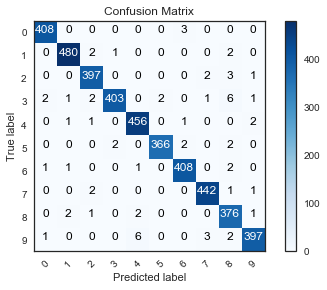

In [37]:
# Look at confusion matrix
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                    horizontalalignment='center',
                    color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(10))

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set.

However, it seems that our CNN has some little troubles with digit 3, since 6 images of 3 from the dataset misclassified as 8. Sometime it is very difficult to catch the difference between 3 and 8 when curves are almost circle. Same is in the case of 4 and 9.

##### Investigating Errors

We want to see the most important errors. For that purpose, we need to get the difference between the probabilities of real values and the predicted ones in the results.

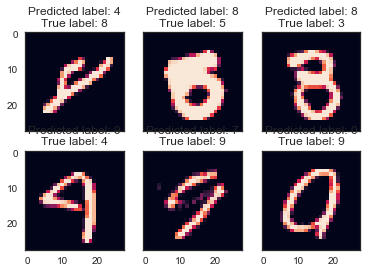

In [38]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """
    This function shows 6 images with their predicted and real labels
    """
    
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row, col].set_title("Predicted label: {}\nTrue label: {}" . format(pred_errors[error], obs_errors[error]))
            n += 1
            
# Probabilties of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Differences between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intrigous.

For above six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for the one the 8 that is very close to a 4. That last 9 is also very misleading, it seems for me that is a 0.

In [39]:
# Predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results, axis=1)

results = pd.Series(results, name="Label")

In [40]:
submission = pd.concat([pd.Series(range(1, 28001), name="ImageId"), results], axis=1)

submission.to_csv("cnn_mnist_datagen_submitted.csv", index=False)